In [1]:
import numpy as np
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
import random

In [2]:
# For better performance GPU is recommended
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
from fbm import FBM

In [1235]:
grid_points = 128
num_of_train = 40000
num_of_test = 10000
batch = 100
epochs = 12

regularised = True
CNN = True


In [1236]:
# Generating H randomly and then creating fGn-s
# %%time
# train_data = []


# num_test = num_of_train
# rand_test = []

# for j in range(num_test):
#   H = random.uniform(0.01,1.0)
  
#   f = FBM(n=grid_points, hurst=H, length=1, method='daviesharte')
  

#   train_data.append((f.fgn(), H))


In [1237]:
# H generated from 0.05 grid, behaves better for training
# %%time

# train_data = []

# for H in np.arange(0.05,1.0,0.05):
#   f = FBM(n=grid_points, hurst=H, length=1, method='daviesharte')
#   for i in range(500):
#     train_data.append((f.fgn(), H))

# from random import shuffle
# shuffle(train_data)

In [1238]:
# # Training data, well behaved H
# with open('notrandom_regression_train_data_grid128', 'rb') as fp:
#     train_data = pickle.load(fp)

In [1239]:

with open('regression_train_data_grid128', 'rb') as fp:
    train_data = pickle.load(fp)[:num_of_train]

In [1240]:
if regularised:
    normalised_train_data = []
    for tup in train_data:
        normalised_train_data.append((tup[0]/np.average(np.abs(tup[0])),tup[1]))
    train_data = normalised_train_data

In [1241]:
# Testing data, random H
with open ('regression_train_data_grid128', 'rb') as fp:
    save = pickle.load(fp)[num_of_train:]

In [1242]:
if regularised:
    normalised_save_data = []
    for tup in save:
        normalised_save_data.append((tup[0]/np.average(np.abs(tup[0])),tup[1]))
    save = normalised_save_data

In [1243]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(save, batch_size=batch, shuffle=False)

In [1244]:
class CNN_simplistic(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        
        self.fc1 = nn.Linear(grid_points, 256)
        self.fc2 = nn.Linear(256, 190)
        self.fc3 = nn.Linear(190, 190)
        self.fc4 = nn.Linear(190, 1)
        self.dropout = nn.Dropout(p)

    def forward(self, x):

        x = self.fc1(x)
        x = F.relu(x)
        
        #fc layer 2
        x = self.fc2(x)
        x = F.relu(x)

        #fc layer 3
        x = self.fc3(x)
        x = F.relu(x)

        x=self.fc4(x)
        
        return x

In [1245]:
if CNN:
    p=0.2
    class CNN_simplistic(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv1d(1, 32, padding = 'same', kernel_size = 11)
            self.conv2 = nn.Conv1d(32, 32, padding = 'same',kernel_size = 11)
            self.conv3 = nn.Conv1d(32, 64, padding = 'same',kernel_size = 11)
            self.conv4 = nn.Conv1d(64, 64, padding = 'same',kernel_size = 11)

            self.fc1 = nn.Linear(grid_points*64//(4*4*2*2), 256)
            self.fc2 = nn.Linear(256, 190)
            self.fc3 = nn.Linear(190, 100)
            self.fc4 = nn.Linear(100, 1)
            self.dropout = nn.Dropout(p)

        def forward(self, x):

            x = self.conv1(x)
            x = F.relu(x)
            x = F.max_pool1d(x,kernel_size = 4)

            x = self.dropout(self.conv2(x))
            x = F.relu(x)
            x = F.max_pool1d(x,kernel_size = 4)


            x = self.conv3(x)
            x = F.relu(x)
            x = F.max_pool1d(x,kernel_size = 2)

            x = self.dropout(self.conv4(x))
            x = F.relu(x)
            x = F.avg_pool1d(x,kernel_size = 2)


            x = x.view(-1,grid_points*64//(4*4*2*2))
            x = self.fc1(x)
            x = F.relu(x)

            #fc layer 2
            x = self.fc2(x)
            x = F.relu(x)

            #fc layer 3
            x = self.fc3(x)
            x = F.relu(x)

            x=self.fc4(x)

            return x

In [1246]:
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange


## Training
# Instantiate model  
model_simp = CNN_simplistic().double().to(device) 



# Loss and Optimizer
base_optimizer = torch.optim.SGD
optimizer = torch.optim.Adam(model_simp.parameters(), lr=0.001)
criterion = nn.MSELoss()




# Iterate through train set minibatchs 
for epoch in trange(epochs):  
    for images, labels in tqdm(train_loader):
        images = images[:,None,:].to(device)
        labels = labels.to(device)
        # Zero out the gradients
        optimizer.zero_grad()

        # ADAM
        # Forward pass
        x = images
        y = model_simp(x)
        loss = criterion(torch.squeeze(y), torch.squeeze(labels))


        
        # Backward pass
        loss.backward()
        optimizer.step()

In [1247]:
# # Test loader for Hurst package:
# from hurst import compute_Hc, random_walk
# num = 1000
# rand_test = []

# for j in range(num):
#     H = random.uniform(0.001,1.0)
  
#     fbm = random_walk(128, proba=H)
  

#     rand_test.append((np.array(fbm), H))

# test_loader = torch.utils.data.DataLoader(rand_test, batch_size=batch, shuffle=False)


In [1248]:
## Testing alone
for allowed_error in np.arange(0.01,0.1,0.01):
    correct = 0
    
    


    with torch.no_grad():
        # Iterate through test set minibatchs 
        for images, labels in test_loader:


            images = images[:,None,:].to(device)
            labels = labels.to(device)

            # Forward pass
            x = images  
#             print(labels.shape)
            
            y = torch.reshape(model_simp(x), (batch,))
            
            


            correct += torch.sum((abs(labels-y)<allowed_error).float())
    
    print(f'Accuracy with threshold {allowed_error}: {100*correct/num_of_test}%')

Accuracy with threshold 0.01: 13.569999694824219%
Accuracy with threshold 0.02: 28.440000534057617%
Accuracy with threshold 0.03: 41.83000183105469%
Accuracy with threshold 0.04: 52.08000183105469%
Accuracy with threshold 0.05: 61.689998626708984%
Accuracy with threshold 0.060000000000000005: 70.19000244140625%
Accuracy with threshold 0.06999999999999999: 77.61000061035156%
Accuracy with threshold 0.08: 83.58999633789062%
Accuracy with threshold 0.09: 87.88999938964844%


In [1249]:
## Testing R/S
for allowed_error in np.arange(0.01,0.1,0.01):
#     correct = 0
    RScorrect = 0
    


    with torch.no_grad():
        # Iterate through test set minibatchs 
        for images, labels in test_loader:


            images = images[:,None,:].to(device)
            labels = labels.to(device)

            # Forward pass
            x = images  
    #         print(labels)
            
#             y = torch.reshape(model_simp(x), (batch,))
            x = x.view(-1,128)
            for i in range(batch):
                H,_,_ = compute_Hc(x[i], kind='change', simplified=True)
                if np.abs(H-labels[i])<allowed_error:
                    RScorrect+=1


#             correct += torch.sum((abs(labels-y)<allowed_error).float())
    
#     print(f'NN accuracy with threshold {allowed_error}: {100*correct/num_of_test}%')
    print(f'R/S accuracy with threshold {allowed_error}: {100*RScorrect/num_of_test}%')

R/S accuracy with threshold 0.01: 4.25%
R/S accuracy with threshold 0.02: 8.88%
R/S accuracy with threshold 0.03: 13.16%
R/S accuracy with threshold 0.04: 17.33%
R/S accuracy with threshold 0.05: 21.8%
R/S accuracy with threshold 0.060000000000000005: 26.15%
R/S accuracy with threshold 0.06999999999999999: 30.28%
R/S accuracy with threshold 0.08: 34.26%
R/S accuracy with threshold 0.09: 38.91%


In [1250]:
# Individual checking
hurst = 0.5
# a = 0
# for i in range(10):
#     f = FBM(n=grid_points, hurst=hurst, length=1, method='daviesharte')
#     g =f.fgn()
#     g = g/np.average(np.abs(g))
#     plt.plot(np.linspace(0,1,128),g)
#     t = torch.tensor(g)[None,:].to(device)
#     a += float(model_simp(t))
#     print(float(model_simp(t)))
    
# print(a/10)

In [1251]:
f = FBM(n=grid_points, hurst=hurst, length=1, method='daviesharte')
g =f.fbm()
g = g/np.average(np.abs(g))

In [1252]:

from hurst import compute_Hc, random_walk

# Use random_walk() function or generate a random walk series manually:
# series = random_walk(99999, cumprod=True)
# np.random.seed(42)
# random_changes = 1. + np.random.randn(99999) / 1000.
# series = np.cumprod(random_changes)  # create a random walk from random changes

# Evaluate Hurst equation
H, c, data = compute_Hc(g, kind='change', simplified=True)

print(H)

0.21424536674628591


In [1253]:
# import copy
# from hurst import compute_Hc, random_walk
# newfbm = random_walk(129, proba=hurst)

# H, c, data = compute_Hc(newfbm, kind='random_walk', simplified=True)
# print(H)

# # newfbm = np.array(newfbm)
# # lis = []
# # for i in range(128):
# #     lis.append(newfbm[i+1]-newfbm[i])
# # lis  = np.array(lis)
# # lis_orig = copy.deepcopy(lis)

# # lis = torch.tensor(lis)[None,:].to(device)
# # model_simp(lis)


In [1254]:
# a = 0
# for i in range(20):
#     newfbm = random_walk(129, proba=hurst)
#     newfbm = np.array(newfbm)
#     lis = []
#     for i in range(128):
#         lis.append(newfbm[i+1]-newfbm[i])
#     lis  = np.array(lis)
#     lis_orig = copy.deepcopy(lis)/np.average(np.abs(lis))
#     plt.plot(np.linspace(0,1,128),lis_orig)
#     lis = torch.tensor(lis_orig)[None,:].to(device)
#     a += float(model_simp(lis))
#     print(model_simp(lis))
# print()
# print(a/20)

In [1255]:
import pandas as pd

In [1256]:
import yfinance as yf

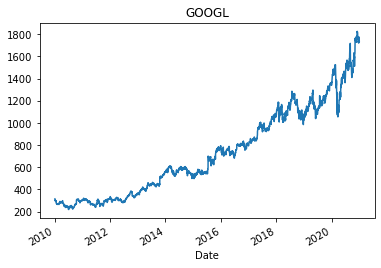

In [1257]:
market = 'GOOGL'
spy_df = yf.download(market, 

                     start="2010-01-01", 

                     end="2020-12-31", 

                     progress=False)

spy_df["Adj Close"].plot(title=market);

In [1270]:
values = spy_df["Adj Close"].values
start = 1 
values = np.array(values)
values = values[start:start+129]
lis = []
for i in range(128):
    lis.append(values[i+1]-values[i])
values = np.array(lis)
values = values/np.average(np.abs(values))

print(values)

[-2.41709214 -2.17584952  1.21699724 -0.13982852 -1.6334284  -0.52090904
  0.42410467 -1.51356601  1.17089993 -1.10790026  0.39490971 -5.0662168
 -1.53815125  0.37186105 -0.04917047 -1.20009489 -0.66842982  0.47327514
 -0.29194967  1.49051735 -2.15741059  0.69301505  0.3349832   0.4563728
 -0.30578823  0.29964192 -0.50401606  1.25695762 -0.47482109  0.76985328
 -0.37800736  0.31346175 -1.18780228 -0.55317716 -0.77445364  0.05685336
  0.9050627   1.28615259  0.65459125  1.42444453  1.47822474 -0.26583722
 -0.35188555  2.4985401   0.72067344 -0.24586172 -2.5138965   0.31038859
  0.05531678  0.12908185 -0.98343751 -0.38415367 -1.30611872  1.27999691
  0.85281908 -0.02919497 -0.03687785  0.65460062  0.06299966  0.25815434
  0.33959293 -0.42871441 -0.71913686  0.60695736 -0.1951453   1.00033049
  2.15741059  0.34266608  0.96806237 -6.93781467 -0.00768289  0.75908787
 -0.11370671 -1.11250999 -0.31808085 -2.0513774  -0.39644628  0.0199755
  0.43178756 -0.96807174  0.75294156 -3.72321554  0.52

In [1262]:
# for start in range(len(spy_df["Adj Close"].values)-130):
#     values = spy_df["Adj Close"].values

#     values = np.array(values)
#     values = values[start:start+129]

#     # H, c, data = compute_Hc(values, kind='random_walk', simplified=True)
#     # print(H)

#     lis = []
#     for i in range(128):
#         lis.append(values[i+1]-values[i])
#     values = np.array(lis)
#     values = values/np.average(np.abs(values))
# #     plt.plot(values)

#     values = torch.tensor(values)[None,:].to(device)
    
#     print(model_simp(values))

In [1259]:
# values = torch.tensor(values)[None,:].to(device)
# model_simp(values)

0.7157479981781395


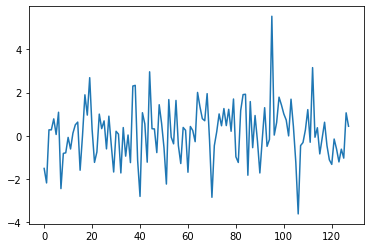

In [1260]:
start = 1
values = spy_df["Adj Close"].values

values = np.array(values)
values = values[0:10*128+1:10]

H, c, data = compute_Hc(values, kind='random_walk', simplified=True)
print(H)

lis = []
for i in range(128):
    lis.append(values[i+1]-values[i])
values = np.array(lis)
values = values/np.average(np.abs(values))
plt.plot(values)

In [1261]:
values = torch.tensor(values)[None,:].to(device)
model_simp(values)

tensor([[0.5502]], dtype=torch.float64, grad_fn=<AddmmBackward0>)